In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

longtail_df = pd.read_pickle("../../data/processed/longtail_indicator.pkl")
rating_df = pd.read_pickle("../../data/processed/rating_session.pkl")

num_items = longtail_df["item_id"].max() + 1
rating_df

,user_id,date,item_id,rating,is_head
0,5,2015-03-27,"[1740, 2122, 5909, 7031, 10230, 10229]","[4.0, 5.0, 4.0, 5.0, 4.0, 5.0]","[0, 1, 1, 1, 1, 1]"
1,5,2016-02-24,"[6468, 7833, 7390, 5752, 15457, 26034]","[4.0, 4.0, 5.0, 4.0, 5.0, 5.0]","[0, 0, 0, 1, 1, 1]"
2,5,2016-02-24,"[7833, 7390, 5752, 15457, 26034, 10345]","[4.0, 5.0, 4.0, 5.0, 5.0, 5.0]","[0, 0, 1, 1, 1, 1]"
3,5,2016-02-24,"[7390, 5752, 15457, 26034, 10345, 18335]","[5.0, 4.0, 5.0, 5.0, 5.0, 5.0]","[0, 1, 1, 1, 1, 1]"
4,9,2014-03-04,"[450, 451, 12373, 24897, 4126, 18538]","[5.0, 5.0, 2.0, 1.0, 5.0, 4.0]","[0, 0, 0, 1, 1, 1]"
...,...,...,...,...,...
16888,4993,2019-04-09,"[8394, 12235, 25185, 21281, 23606, 14018]","[3.0, 5.0, 5.0, 4.0, 5.0, 5.0]","[1, 1, 1, 1, 1, 1]"
16889,4993,2019-04-09,"[12235, 25185, 21281, 23606, 14018, 21547]","[5.0, 5.0, 4.0, 5.0, 5.0, 5.0]","[1, 1, 1, 1, 1, 1]"
16890,4993,2019-09-16,"[15370, 5784, 17893, 16523, 11703, 7327]","[5.0, 4.0, 5.0, 4.0, 4.0, 5.0]","[0, 0, 0, 0, 1, 1]"
16891,4993,2019-09-16,"[5784, 17893, 16523, 11703, 7327, 27390]","[4.0, 5.0, 4.0, 4.0, 5.0, 3.0]","[0, 0, 0, 1, 1, 1]"


In [2]:
num_items

27583

In [3]:
x = rating_df.explode(["item_id", "is_head", "rating"])[["item_id", "is_head"]]
x = x.drop_duplicates(["item_id", "is_head"])
is_head_lst = torch.tensor(x["is_head"].tolist()).long()
item_id_lst = torch.tensor(x["item_id"].tolist()).long()
is_head_lst[is_head_lst==0].shape, is_head_lst[is_head_lst==1].shape

(torch.Size([8289]), torch.Size([4513]))

In [4]:
head_mapping_lst = torch.empty(num_items+1).long()
head_mapping_lst[item_id_lst]=is_head_lst
head_mapping_lst = head_mapping_lst.cuda()
head_mapping_lst[head_mapping_lst==1].shape, head_mapping_lst

(torch.Size([4513]), tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0'))

In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

item_sequences = rating_df['item_id'].tolist()
user_ids = rating_df['user_id'].tolist()


class SessionDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        return torch.tensor(sequence[:-1]), torch.tensor(sequence[-1])
    
train_data, test_data = train_test_split(item_sequences, test_size=0.2, random_state=42)

# Hyperparameters
embedding_dim = 128
hidden_dim = 128
num_epochs = 1000
learning_rate = 1e-4
batch_size = 512
# 512 1e-4 0.4369
# 512 53-5 0.4404

train_loader = DataLoader(SessionDataset(train_data), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(SessionDataset(test_data), batch_size=batch_size, shuffle=False)

In [6]:
import torch.optim as optim
import sys
sys.path.append("../")
from model import GRURecommender



model = GRURecommender(num_items, embedding_dim, hidden_dim).cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
num_items, item_id_lst.max()

(27583, tensor(27580))

In [8]:
from sklearn.metrics import recall_score
from tqdm import tqdm
from copy import deepcopy
import warnings
warnings.filterwarnings('always')

model_parameters = deepcopy(model.state_dict())
K=20

recall_records, tail_records = [], []

def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs, early_stopping_patience=5):
    global model_parameters
    best_val_recall = -float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for inputs, target in tqdm(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs.cuda())
            loss = criterion(outputs, target.cuda())

            loss.backward()
            optimizer.step()
            total_loss += loss.detach().cpu().item()

        val_loss, val_recall, val_tail = evaluate(model, val_loader, criterion)
        recall_records.append(val_recall)
        tail_records.append(val_tail)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}, '
              f'Val Loss: {val_loss:.4f},  Recall@20: {val_recall:.4f} Tail@20: {val_tail:.4f}')
        
        if val_recall > best_val_recall:
            best_val_recall = val_recall
            patience_counter = 0
            model_parameters = deepcopy(model.state_dict())
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered")
                break

def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss = 0

    pred_lst, target_lst = [], []
    tail_lst = []
    
    with torch.no_grad():
        for idx, (inputs, target) in enumerate(tqdm(data_loader)):
            outputs = model(inputs.cuda())
            loss = criterion(outputs, target.cuda())
            total_loss += loss.detach().cpu().item()

            top_pred_idx = torch.argsort(outputs, dim=1, descending=True)[:, :K]
            tail_lst.append(head_mapping_lst[top_pred_idx])

            pred_lst.append(top_pred_idx.detach().cpu())
            target_lst.append(target.unsqueeze(dim=1).detach().cpu())
    
    pred_lst = torch.cat(pred_lst, dim=0)
    target_lst = torch.cat(target_lst, dim=0)
    tail_lst = torch.cat(tail_lst, dim=0)

    recall, tail = [], []
    for pred_idx, target_idx, is_tail in zip(pred_lst, target_lst, tail_lst):
        num_hit = target_idx[torch.isin(target_idx, pred_idx)].shape[0]
        recall.append(num_hit/target_idx.shape[0])
        # print(is_tail, is_tail.shape, is_tail[is_tail==0].shape[0], is_tail[is_tail==0].shape[0]/K)
        tail.append(is_tail[is_tail==0].shape[0]/K)

    avg_loss = total_loss / len(data_loader)
    avg_recall = np.mean(recall)    
    avg_tail = np.mean(tail)
    return avg_loss, avg_recall, avg_tail

train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs)


100%|██████████| 7/7 [00:00<00:00, 59.21it/s]


Epoch [1/1000], Loss: 10.2205, Val Loss: 10.2019,  Recall@20: 0.0018 Tail@20: 0.7407


100%|██████████| 7/7 [00:00<00:00, 60.93it/s]


Epoch [2/1000], Loss: 10.1655, Val Loss: 10.1648,  Recall@20: 0.0050 Tail@20: 0.5052


100%|██████████| 7/7 [00:00<00:00, 61.67it/s]


Epoch [3/1000], Loss: 10.1097, Val Loss: 10.1249,  Recall@20: 0.0095 Tail@20: 0.2431


100%|██████████| 7/7 [00:00<00:00, 58.51it/s]


Epoch [4/1000], Loss: 10.0489, Val Loss: 10.0799,  Recall@20: 0.0136 Tail@20: 0.0838


100%|██████████| 7/7 [00:00<00:00, 61.91it/s]


Epoch [5/1000], Loss: 9.9795, Val Loss: 10.0272,  Recall@20: 0.0178 Tail@20: 0.0273


100%|██████████| 7/7 [00:00<00:00, 61.97it/s]


Epoch [6/1000], Loss: 9.8970, Val Loss: 9.9624,  Recall@20: 0.0201 Tail@20: 0.0096


100%|██████████| 7/7 [00:00<00:00, 60.12it/s]


Epoch [7/1000], Loss: 9.7930, Val Loss: 9.8754,  Recall@20: 0.0260 Tail@20: 0.0034


100%|██████████| 7/7 [00:00<00:00, 60.34it/s]


Epoch [8/1000], Loss: 9.6462, Val Loss: 9.7387,  Recall@20: 0.0296 Tail@20: 0.0009


100%|██████████| 7/7 [00:00<00:00, 61.04it/s]


Epoch [9/1000], Loss: 9.3924, Val Loss: 9.4596,  Recall@20: 0.0346 Tail@20: 0.0000


100%|██████████| 7/7 [00:00<00:00, 62.12it/s]


Epoch [10/1000], Loss: 8.8536, Val Loss: 8.8851,  Recall@20: 0.0444 Tail@20: 0.0000


100%|██████████| 7/7 [00:00<00:00, 62.20it/s]


Epoch [11/1000], Loss: 8.1834, Val Loss: 8.5906,  Recall@20: 0.0462 Tail@20: 0.0000


100%|██████████| 7/7 [00:00<00:00, 60.53it/s]


Epoch [12/1000], Loss: 7.9453, Val Loss: 8.5621,  Recall@20: 0.0562 Tail@20: 0.0000


100%|██████████| 7/7 [00:00<00:00, 52.27it/s]


Epoch [13/1000], Loss: 7.8717, Val Loss: 8.5510,  Recall@20: 0.0630 Tail@20: 0.0000


100%|██████████| 7/7 [00:00<00:00, 61.47it/s]


Epoch [14/1000], Loss: 7.8213, Val Loss: 8.5429,  Recall@20: 0.0610 Tail@20: 0.0000


100%|██████████| 7/7 [00:00<00:00, 61.37it/s]


Epoch [15/1000], Loss: 7.7913, Val Loss: 8.5410,  Recall@20: 0.0636 Tail@20: 0.0000


100%|██████████| 7/7 [00:00<00:00, 61.03it/s]


Epoch [16/1000], Loss: 7.7607, Val Loss: 8.5390,  Recall@20: 0.0672 Tail@20: 0.0000


100%|██████████| 7/7 [00:00<00:00, 60.96it/s]


Epoch [17/1000], Loss: 7.7336, Val Loss: 8.5377,  Recall@20: 0.0660 Tail@20: 0.0000


100%|██████████| 7/7 [00:00<00:00, 57.79it/s]


Epoch [18/1000], Loss: 7.7115, Val Loss: 8.5375,  Recall@20: 0.0645 Tail@20: 0.0000


100%|██████████| 7/7 [00:00<00:00, 61.67it/s]


Epoch [19/1000], Loss: 7.6909, Val Loss: 8.5368,  Recall@20: 0.0639 Tail@20: 0.0000


100%|██████████| 7/7 [00:00<00:00, 45.66it/s]


Epoch [20/1000], Loss: 7.6672, Val Loss: 8.5366,  Recall@20: 0.0663 Tail@20: 0.0000


100%|██████████| 7/7 [00:00<00:00, 62.13it/s]


Epoch [21/1000], Loss: 7.6466, Val Loss: 8.5357,  Recall@20: 0.0663 Tail@20: 0.0000
Early stopping triggered


In [9]:
model.load_state_dict(model_parameters)

avg_loss, avg_recall, avg_tail = evaluate(model, test_loader, criterion)
print(avg_loss, avg_recall, avg_tail)

# 12.022144079208374 0.3539857738533235

100%|██████████| 7/7 [00:00<00:00, 58.96it/s]


8.53898252759661 0.06717963894643386 0.0


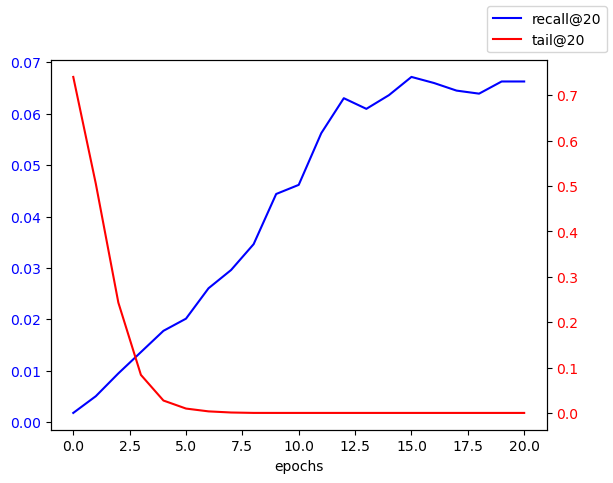

In [17]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(0, len(recall_records))

fig, ax1 = plt.subplots()

ax1.plot(x, recall_records, 'b', label=f'recall@{K}')
ax1.set_xlabel('epochs')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(x, tail_records, 'r-', label=f'tail@{K}')
ax2.tick_params(axis='y', labelcolor='r')

fig.legend()

plt.show()


In [11]:
torch.save({
    "state_dict": model.cpu().state_dict(),
    "num_items": num_items,
    "embedding_dim":embedding_dim,
    "hidden_dim": hidden_dim
}, "../parameters/session.pth")